In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 



In [2]:
from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from functools import partial
import pandas as pd
%config Completer.use_jedi = False

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1767: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 144 results
transitions_data returned 335 results
total_population_data returned 108 results
initialization time:  5.281620025634766
simulation_time:  6.075662136077881
initialization time:  5.27115273475647
simulation_time:  6.1463727951049805
initialization time:  5.327155113220215
simulation_time:  6.2763237953186035


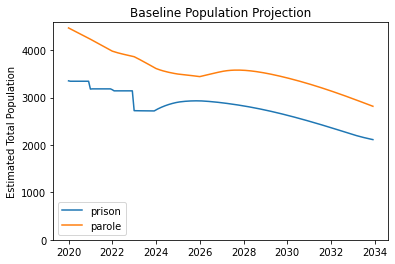

In [3]:
path_from_state_folder = 'SC/SC_prison_model_inputs.yaml'
display_compartments = ['prison', 'parole']
test_sim = SuperSimulationFactory.build_super_simulation('../state/' + path_from_state_folder)
test_sim.simulate_baseline(display_compartments)

initialization time:  6.211281776428223
initialization time:  5.455565690994263
simulation_time:  6.250986814498901
simulation_time:  6.326626777648926


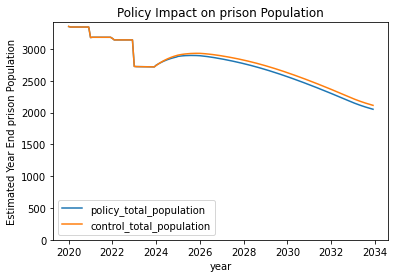

In [6]:
# Policy Option Methods
t = test_sim.initializer.data_dict['transitions_data']
pt = t[t.compartment == 'prison']
import numpy as np
LOS = np.average(pt.compartment_duration, weights = pt.total_population)
approval_rate = 0.34
hearings = 2831
total_population = 18171
GRANT_RATE = LOS / 12 * approval_rate * hearings / total_population 


def reduce_parole_eligibility_date(retroactive=False):
    return partial(TransitionTable.apply_reduction, 
                   reduction_df=pd.DataFrame({
                       'outflow':['parole'],
                       'affected_fraction': [GRANT_RATE],
                       'reduction_size': [1 - 0.65/0.85]
                   }),
                   reduction_type='*',
                   retroactive=retroactive)


policy_list = [
    SparkPolicy(policy_fn=reduce_parole_eligibility_date(True),
                spark_compartment='prison',
                sub_population={'crime_type': 'x'},
                policy_ts=120,
                apply_retroactive=True)
]
    
test_results = test_sim.simulate_policy(policy_list, 'prison')

In [15]:
simulation_tag = 'SC_HB3623'
test_sim.upload_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison parole release
 year                                       
 2020.000000              0.0    0.0     0.0
 2020.083333              0.0    0.0     0.0
 2020.166667              0.0    0.0     0.0
 2020.250000              0.0    0.0     0.0
 2020.333333              0.0    0.0     0.0
 ...                      ...    ...     ...
 2033.583333  18970776.685372    0.0     0.0
 2033.666667  19115072.383491    0.0     0.0
 2033.750000  19258854.726419    0.0     0.0
 2033.833333  19402129.967859    0.0     0.0
 2033.916667  19544904.846145    0.0     0.0
 
 [168 rows x 3 columns],
 'compartment_life_years_diff':                  prison      parole      release
 year                                            
 2020.000000         0.0         0.0          0.0
 2020.083333         0.0         0.0          0.0
 2020.166667         0.0         0.0          0.0
 2020.250000         0.0         0.0          0.0
 2020.333333         0.0         0.0    